In [1]:
import torch
import numpy as np
import pandas as pd
import yfinance as yf
import requests
import matplotlib.pyplot as plt
from pathlib import Path
from xgboost import XGBRegressor
from chronos import Chronos2Pipeline
import os

c:\capstone_project_unfc\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# --- 1) SETTINGS ---
SYMBOL = "TSLA"
VIX_SYMBOL = "^VIX"
INTERVAL = "1wk"
MODEL_ID = "amazon/chronos-2"
ALPHA_VANTAGE_API_KEY = os.getenv('ALPHAVANTAGE_API_KEY') 
TEST_SIZE = 30
MIN_CONTEXT = 64
REDUCED_LOOKBACK = 3 
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

XGB_PARAMS = dict(
    n_estimators=500,
    learning_rate=0.02,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
    booster='dart' # Better for handling many technical features
)

In [5]:
# --- 2) DATA LOADING FUNCTIONS ---
def load_standardized_data(symbol):
    data = yf.download(symbol, period="5y", interval=INTERVAL, auto_adjust=True, multi_level_index=False, progress=False)
    data = data.reset_index()
    data.columns = [str(c).lower() for c in data.columns]
    date_col = 'date' if 'date' in data.columns else 'index'
    data = data.rename(columns={date_col: 'timestamp'})
    data["timestamp"] = pd.to_datetime(data["timestamp"]).dt.tz_localize(None)
    return data

def fetch_av_sentiment(symbol, api_key):
    print(f"Fetching Alpha Vantage Sentiment for {symbol}...")
    url = f"https://www.alphavantage.co/query?function=NEWS_SENTIMENT&tickers={symbol}&limit=1000&apikey={api_key}"
    r = requests.get(url)
    data = r.json()
    
    sentiment_list = []
    for feed in data.get('feed', []):
        for ticker in feed.get('ticker_sentiment', []):
            if ticker['ticker'] == symbol:
                sentiment_list.append({
                    'timestamp': feed['time_published'],
                    'score': float(ticker['ticker_sentiment_score']),
                    'relevance': float(ticker['relevance_score'])
                })
    
    if not sentiment_list:
        return pd.DataFrame(columns=['sentiment_score'])
        
    sent_df = pd.DataFrame(sentiment_list)
    sent_df['timestamp'] = pd.to_datetime(sent_df['timestamp'])
    
    # Calculate Weighted Sentiment: Relevance * Score
    sent_df['weighted_score'] = sent_df['score'] * sent_df['relevance']
    
    # Resample to weekly mean to match price data
    weekly_sent = sent_df.set_index('timestamp').resample('1W').mean()
    return weekly_sent[['weighted_score']].rename(columns={'weighted_score': 'sentiment'})

In [ ]:
# --- 3) FEATURE ENGINEERING ---
df = load_standardized_data(SYMBOL)
vix_raw = load_standardized_data(VIX_SYMBOL)
sentiment_raw = fetch_av_sentiment(SYMBOL, ALPHA_VANTAGE_API_KEY)

REPO_ROOT = Path.cwd().parent.parent
ART = REPO_ROOT / "model" / "notebooks" / "artifacts"
ART.mkdir(parents=True, exist_ok=True)

# Save the raw sentiment data
sentiment_path = ART / f"{SYMBOL}_news_sentiment_raw.parquet"
sentiment_raw.to_parquet(sentiment_path)
print(f"Sentiment data saved to: {sentiment_path}")




def add_advanced_features(df, vix_raw, sentiment_raw):
    close = df['close'].squeeze()
    high = df['high'].squeeze()
    low = df['low'].squeeze()
    vol = df['volume'].squeeze()
    
    # Technical Indicators
    df['roc'] = ((close - close.shift(4)) / close.shift(4)) * 100
    df['obv'] = (np.sign(close.diff()) * vol).fillna(0).cumsum()
    h14, l14 = high.rolling(14).max(), low.rolling(14).min()
    df['williams_r'] = ((h14 - close) / (h14 - l14)) * -100
    df['stoch_k'] = ((close - l14) / (h14 - l14)) * 100
    
    # Macro & Sentiment Join
    vix = vix_raw.set_index("timestamp")["close"].rename("vix")
    df = df.set_index("timestamp").join(vix).join(sentiment_raw).ffill().fillna(0)
    
    # Sentiment Dynamics
    df['sentiment_ma_4'] = df['sentiment'].rolling(4).mean()
    
    # Cyclic Seasonality
    df['month_sin'] = np.sin(2 * np.pi * df.index.month / 12)
    
    # Prevent Leakage: Shift all exogenous variables
    exog_cols = ['roc', 'obv', 'williams_r', 'stoch_k', 'vix', 'sentiment', 'sentiment_ma_4', 'month_sin']
    for col in exog_cols:
        df[col] = df[col].shift(1)
        
    return df, exog_cols

# sentiment_raw = pd.read_parquet(sentiment_path)

feat, indicator_cols = add_advanced_features(df, vix_raw, sentiment_raw)

Fetching Alpha Vantage Sentiment for TSLA...
Sentiment data saved to: c:\capstone_project_unfc\model\notebooks\artifacts\TSLA_news_sentiment_raw.parquet


In [7]:
sentiment_raw

,sentiment
timestamp,
2026-01-25,0.067864
2026-02-01,0.054894
2026-02-08,0.035449
2026-02-15,0.004497
2026-02-22,0.016934
2026-03-01,0.038113


In [8]:
# Add minimal return lags
for i in range(1, REDUCED_LOOKBACK + 1):
    feat[f"ret_lag_{i}"] = feat["close"].pct_change().shift(i)

feat["y_true"] = feat["close"].shift(-1)
feat = feat.dropna()

In [9]:
# --- 4) CHRONOS OOS GENERATION ---
pipeline = Chronos2Pipeline.from_pretrained(MODEL_ID, device_map=DEVICE, torch_dtype=torch.float32)

def chronos_predict(train_series):
    input_df = pd.DataFrame({"item_id": ["ASSET"] * len(train_series), "timestamp": train_series.index, "target": train_series.values})
    forecast_df = pipeline.predict_df(input_df, prediction_length=1, quantile_levels=[0.5])
    return float(forecast_df.iloc[0]["0.5"])

print("Generating Chronos OOS features...")
chronos_results = {feat.index[i]: chronos_predict(feat["close"].iloc[:i]) for i in range(len(feat)) if i >= MIN_CONTEXT}
feat["chronos_q50"] = pd.Series(chronos_results)
model_df = feat.dropna(subset=["chronos_q50", "y_true"]).copy()

`torch_dtype` is deprecated! Use `dtype` instead!
`torch_dtype` is deprecated! Use `dtype` instead!


Generating Chronos OOS features...


c:\capstone_project_unfc\env\Lib\site-packages\chronos\chronos2\dataset.py:89: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_numpy.cpp:219.)
  task_target = torch.from_numpy(task_target)


In [ ]:
feature_cols = indicator_cols + [c for c in model_df.columns if "lag" in c] + ["chronos_q50"]

feature_cols

In [10]:
# --- 5) WALK-FORWARD RESIDUAL ENSEMBLE ---


def walk_forward_ensemble(df, features, target_col, test_size):
    preds, importances = [], []
    split_idx = len(df) - test_size
    
    for i in range(split_idx, len(df)):
        train, test_row = df.iloc[:i], df.iloc[i:i+1]
        y_train_residual = train[target_col] - train["chronos_q50"]
        
        model = XGBRegressor(**XGB_PARAMS)
        model.fit(train[features], y_train_residual)
        importances.append(model.feature_importances_)
        
        predicted_error = model.predict(test_row[features])[0]
        y_pred = test_row["chronos_q50"].iloc[0] + predicted_error
        preds.append({"timestamp": test_row.index[0], "y_true": float(test_row[target_col].iloc[0]), "y_pred": y_pred})
        
    return pd.DataFrame(preds), np.mean(importances, axis=0)

pred_ens, mean_importance = walk_forward_ensemble(model_df, feature_cols, "y_true", TEST_SIZE)

In [11]:
mae = np.mean(np.abs(pred_ens["y_true"] - pred_ens["y_pred"]))
rmse = np.sqrt(np.mean((pred_ens["y_true"] - pred_ens["y_pred"]) ** 2))
mape = np.mean(np.abs((pred_ens["y_true"] - pred_ens["y_pred"]) / pred_ens["y_true"])) * 100

print(f"\nFinal Ensemble Metrics:")
print(f"  MAE:  {mae:,.2f}")
print(f"  RMSE: {rmse:,.2f}")
print(f"  MAPE: {mape:.2f}%")


Final Ensemble Metrics:
  MAE:  28.63
  RMSE: 35.09
  MAPE: 6.84%


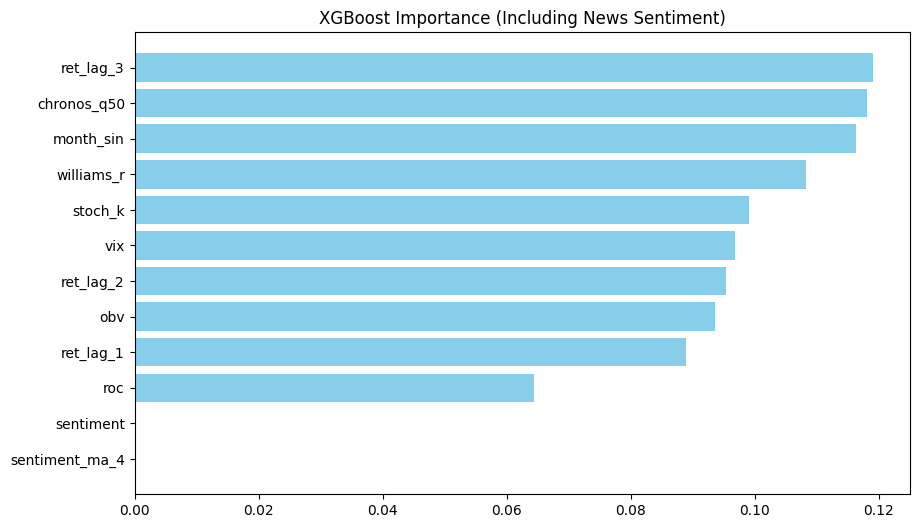

In [12]:
# --- 6) RESULTS & IMPORTANCE PLOT ---
importance_df = pd.DataFrame({'feature': feature_cols, 'importance': mean_importance}).sort_values('importance', ascending=True)
plt.figure(figsize=(10, 6)); plt.barh(importance_df['feature'], importance_df['importance'], color='skyblue')
plt.title("XGBoost Importance (Including News Sentiment)"); plt.show()